
# Keras

The most convenient way to use TensorFlow with neural networks is through [Keras](http://keras.io). It provides a high-level interface that is somewhat a compromise between very high-level abstractions like scikit-learn and the complete control of every detail you get when directly using the low-level APIs of libraries like TensorFlow.

Besides TensorFlow, Keras also supports Theano and CNTK. Code that only uses the high-level Keras API should be able to run in Theano and CNTK as well by just switching the backend. If you only want to use TensorFlow, you can use the version of keras that is directly included in TensorFlow (`tensorflow.keras`)

## Build a model in Keras

In [1]:
import keras

Using TensorFlow backend.


As a quick example, let's again build a model to classify our "Moons" dataset from [NNFromScratch.ipynb](NNFromScratch.ipynb).

In [2]:
from sklearn.datasets import make_moons

In [3]:
x, y = make_moons(n_samples=10000, noise=0.2)

There are 2 main ways to use Keras - via the Sequential or the Functional API. Lets start with `Sequential`. This is convenient for all models where we just have one input and one output Tensor with stacked Layers in between. Here we use the `Dense` layer - which is precisely the fully connected NN layer that applies the $\sigma(W\mathbf{x} + \mathbf{b})$ operation.

In [4]:
from keras.layers import Dense

model = keras.models.Sequential([
    # Hidden layer with 2 inputs, 16 outputs
    Dense(16, activation="relu", input_shape=(2,)),
    # Output layer with 16 inputs (determined automatically) and 1 output
    Dense(1, activation="sigmoid")
])

W0830 11:34:38.823766 139699309127488 deprecation_wrapper.py:119] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 11:34:38.847443 139699309127488 deprecation_wrapper.py:119] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 11:34:38.850755 139699309127488 deprecation_wrapper.py:119] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



How much parameters will our model have? The answer:

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


We can also access the underlying Tensors if needed:

In [6]:
model.inputs

[<tf.Tensor 'dense_1_input:0' shape=(?, 2) dtype=float32>]

In [7]:
model.outputs

[<tf.Tensor 'dense_2/Sigmoid:0' shape=(?, 1) dtype=float32>]

In [8]:
model.weights

[<tf.Variable 'dense_1/kernel:0' shape=(2, 16) dtype=float32_ref>,
 <tf.Variable 'dense_1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'dense_2/kernel:0' shape=(16, 1) dtype=float32_ref>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32_ref>]

In [9]:
model.layers

In [10]:
model.layers[0].input

<tf.Tensor 'dense_1_input:0' shape=(?, 2) dtype=float32>

In [11]:
model.layers[0].output

<tf.Tensor 'dense_1/Relu:0' shape=(?, 16) dtype=float32>

## Train the model

Before we can run the training, we have to "compile" the model. This will configure the loss function and optimization Algorithm. You cat pass each loss from [`keras.losses`](https://keras.io/losses) and each optimizer from [`keras.optimizers`](https://keras.io/optimizers) also as a string with the name if you want to use it with default parameters. Here we want to use the "Adam" optimizer with an adjusted inital learning rate, so we pass it directly.

We could also pass some metrics that we want to monitor during training (in addition to the Loss value).

In [12]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss="binary_crossentropy")

W0830 11:34:39.155314 139699309127488 deprecation_wrapper.py:119] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 11:34:39.170232 139699309127488 deprecation_wrapper.py:119] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0830 11:34:39.177535 139699309127488 deprecation.py:323] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


The API for fitting looks similar to scikit-learn, but has additional options. In fact there also is a *->link* scikit-learn API for Keras if you need that in some context.

In [13]:
history = model.fit(x, y, epochs=3, batch_size=128)

W0830 11:34:39.373313 139699309127488 deprecation_wrapper.py:119] From /home/nikolai/.conda/envs/ml-p3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/3
10000/10000 [==============================] - 1s 93us/step - loss: 0.2587
Epoch 2/3
10000/10000 [==============================] - 0s 22us/step - loss: 0.0997
Epoch 3/3
10000/10000 [==============================] - 0s 21us/step - loss: 0.0956


The returned `History` object contains the monitored metrics (by default the loss).

In [14]:
import matplotlib.pyplot as plt

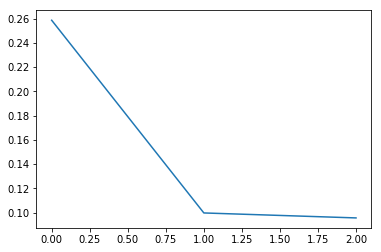

In [15]:
plt.plot(history.epoch, history.history['loss'])

## Run the model

The model can be run using `model.predict`.

In [16]:
import numpy as np

In [17]:
grid = np.meshgrid(
    np.arange(x[:,0].min(), x[:,0].max(), 0.1),
    np.arange(x[:,1].min(), x[:,1].max(), 0.1),
)

In [18]:
xy = np.stack([grid[0].reshape(-1), grid[1].reshape(-1)]).T

In [19]:
scores = model.predict(xy)

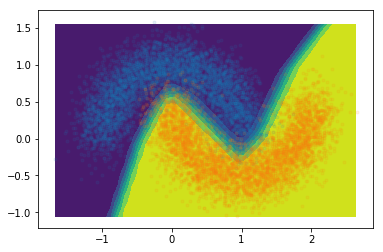

In [20]:
plt.contourf(grid[0], grid[1], scores.reshape(grid[0].shape))
opts = dict(alpha=0.1, marker=".")
plt.scatter(x[y==0][:,0], x[y==0][:,1], **opts)
plt.scatter(x[y==1][:,0], x[y==1][:,1], **opts)

## Functional API

The functional API is very similar to the low-level TensorFlow API. Each layer can be called as a function on an input Tensor and return an output Tensor. One can then build arbitrary computation graphs and finally build a model by passing the input and output Tensors. This is especially useful when we want to organize the processing into different inputs and different outputs or if you want to build computation graphs that have branches.

Suppose we want to do some strangely compilicated processing of the "california housing dataset":

In [21]:
from sklearn.datasets import california_housing

In [22]:
data = california_housing.fetch_california_housing()

In [23]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

For convenience, let's put it into a DataFrame

In [24]:
import pandas as pd

In [25]:
df_housing = pd.DataFrame(data.data)
df_housing.columns = data.feature_names
df_housing['MedHouseVal'] = data.target

In [26]:
df_housing.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [27]:
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [28]:
from keras.layers import Input, Dense, concatenate

inp_feat = Input((5,), name="Features") # ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']
inp_coord = Input((2,), name="Coordinates") # ['Latitude', 'Longitude']
hl_coord = Dense(64, activation="relu")(inp_coord)
joined_inp = concatenate([inp_feat, hl_coord])
hl = Dense(64, activation="relu")(joined_inp)
# no activation function here, this will be a regression target
out_MedInc = Dense(1, name="MedIncOutput")(hl)
joined_inp2 = concatenate([hl, out_MedInc])
hl2 = Dense(64, activation="relu")(joined_inp2)
out_HouseValue = Dense(1, name="HouseValueOutput")(hl2)

In [29]:
housing_model = keras.models.Model(inputs=[inp_feat, inp_coord], outputs=[out_MedInc, out_HouseValue])
housing_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Coordinates (InputLayer)        (None, 2)            0                                            
__________________________________________________________________________________________________
Features (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 64)           192         Coordinates[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 69)           0           Features[0][0]                   
                                                                 dense_3[0][0]                    
__________

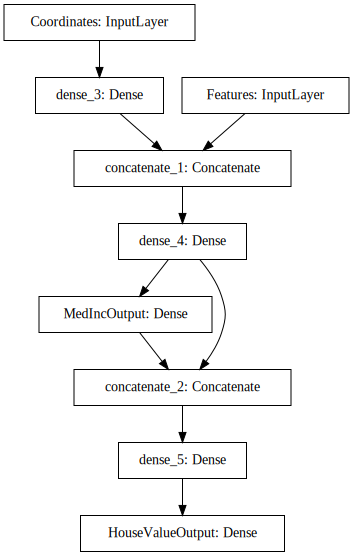

In [30]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(housing_model).create(prog='dot', format='svg'))

Since we named the inputs and outputs, we can give input and target data as dictionaries, but before we want to standardize both the inputs and the targets!

In [31]:
features = ['HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']

In [32]:
coordinates = ['Latitude', 'Longitude']

In [33]:
from sklearn.preprocessing import StandardScaler

In [34]:
scaler = StandardScaler().fit(df_housing.values)

In [35]:
df_trf = df_housing.copy()
df_trf[:] = scaler.transform(df_housing.values)
df_trf.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04,2.064000e+04
mean,6.609700e-17,5.508083e-18,6.609700e-17,-1.060306e-16,-1.101617e-17,3.442552e-18,-1.079584e-15,-8.526513e-15,2.037991e-16
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-1.774299e+00,-2.196180e+00,-1.852319e+00,-1.610768e+00,-1.256123e+00,-2.290000e-01,-1.447568e+00,-2.385992e+00,-1.662641e+00
25%,-6.881186e-01,-8.453931e-01,-3.994496e-01,-1.911716e-01,-5.638089e-01,-6.171062e-02,-7.967887e-01,-1.113209e+00,-7.561633e-01
50%,-1.767951e-01,2.864572e-02,-8.078489e-02,-1.010650e-01,-2.291318e-01,-2.431585e-02,-6.422871e-01,5.389137e-01,-2.353337e-01
75%,4.593063e-01,6.643103e-01,2.519615e-01,6.015869e-03,2.644949e-01,2.037453e-02,9.729566e-01,7.784964e-01,5.014973e-01
max,5.858286e+00,1.856182e+00,5.516324e+01,6.957171e+01,3.025033e+01,1.194191e+02,2.958068e+00,2.625280e+00,2.540411e+00


In [36]:
x_housing = {
    "Features" : df_trf[features].values,
    "Coordinates" : df_trf[coordinates].values,
}
y_housing = {
    "MedIncOutput" : df_trf["MedInc"].values.reshape(-1, 1),
    "HouseValueOutput" : df_trf["MedHouseVal"].values.reshape(-1, 1),
}

We need to specify loss functions for all outputs. If different outputs should be trained with different loss functions, you need to pass a list. The total loss will be the sum of the individual losses. One could also pass `loss_weights` to weight them relative to each other, but we don't do that here.

In [37]:
housing_model.compile(loss='mean_squared_error', optimizer='Adam')

In [38]:
housing_model.fit(x_housing, y_housing, epochs=10, shuffle=True, batch_size=128)

Epoch 1/10
20640/20640 [==============================] - 2s 90us/step - loss: 1.2191 - MedIncOutput_loss: 0.6291 - HouseValueOutput_loss: 0.5900
Epoch 2/10
20640/20640 [==============================] - 1s 31us/step - loss: 0.7535 - MedIncOutput_loss: 0.3430 - HouseValueOutput_loss: 0.4106
Epoch 3/10
20640/20640 [==============================] - 1s 35us/step - loss: 0.6446 - MedIncOutput_loss: 0.3049 - HouseValueOutput_loss: 0.3398
Epoch 4/10
20640/20640 [==============================] - 1s 32us/step - loss: 0.5875 - MedIncOutput_loss: 0.2854 - HouseValueOutput_loss: 0.3022
Epoch 5/10
20640/20640 [==============================] - 1s 32us/step - loss: 0.5555 - MedIncOutput_loss: 0.2668 - HouseValueOutput_loss: 0.2887
Epoch 6/10
20640/20640 [==============================] - 1s 32us/step - loss: 0.5278 - MedIncOutput_loss: 0.2504 - HouseValueOutput_loss: 0.2774
Epoch 7/10
20640/20640 [==============================] - 1s 32us/step - loss: 0.5144 - MedIncOutput_loss: 0.2428 - HouseVal

Did we predict the median income and finally the house price correctly? Let's have a look at the distributions for true and predicted values.

In [39]:
predictions = housing_model.predict(x_housing)

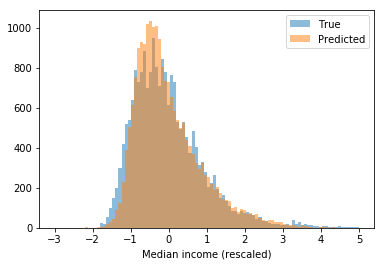

In [40]:
opt = dict(alpha=0.5, bins=100, range=(-3, 5))
plt.hist(df_trf["MedInc"], label="True", **opt)
plt.hist(predictions[0], label="Predicted", **opt)
plt.xlabel("Median income (rescaled)")
plt.legend()

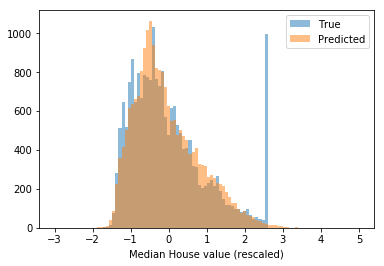

In [41]:
opt = dict(alpha=0.5, bins=100, range=(-3, 5))
plt.hist(df_trf["MedHouseVal"], label="True", **opt)
plt.hist(predictions[1], label="Predicted", **opt)
plt.xlabel("Median House value (rescaled)")
plt.legend()

## Generators

Somtimes the whole training data might not fit into memory or you might want to do some live pre-processing. The simplest way to do this is via [python generators](https://wiki.python.org/moin/Generators)

Let's write a generator that yields an inifite amount of mini batches for our "moon" dataset. The generator should yield batches of (x, y).

In [42]:
def moon_generator(batch_size=128, buffer_size=10000):
    # let's make an infinite generator
    # - in each pass of the loop we will generate `buffer_size` training examples
    while True:
        x, y = make_moons(n_samples=buffer_size, noise=0.4)
        # this is the loop over mini-batches
        for start in range(0, buffer_size, batch_size):
            yield x[start : start + batch_size], y[start : start + batch_size]

Let's make an overly complicated model and train it with "inifinite data"

In [43]:
stupid_model = keras.models.Sequential([
    Dense(1024, activation="relu", input_shape=(2,)),
    Dense(1024, activation="relu"),
    Dense(1024, activation="relu"),
    Dense(1, activation="sigmoid")
])

In [44]:
stupid_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1024)              3072      
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 1025      
Total params: 2,103,297
Trainable params: 2,103,297
Non-trainable params: 0
_________________________________________________________________


In [45]:
stupid_model.compile(optimizer="Adam", loss="binary_crossentropy")

We can use the [`fit_generator`](https://keras.io/models/model/#fit_generator) method to train the model. Since our generator is infinite we have to pass the `steps_per_epoch` Argument that defines how many batches should be used until one epoch is declared finished.

In [46]:
stupid_model.fit_generator(moon_generator(), steps_per_epoch=200, epochs=1)

Epoch 1/1
200/200 [==============================] - 13s 67ms/step - loss: 0.3464


In [47]:
stupid_scores = stupid_model.predict(xy)

In [48]:
def validate_with_generator(model, generator, steps=5):

    # for plotting, just draw a few examples from the generator
    x = []
    y = []
    for i in range(steps):
        data = next(generator)
        x.append(data[0])
        y.append(data[1])
    x = np.concatenate(x)
    y = np.concatenate(y)
    
    grid = np.meshgrid(
        np.arange(x[:,0].min(), x[:,0].max(), 0.1),
        np.arange(x[:,1].min(), x[:,1].max(), 0.1),
    )
    
    xy = np.stack([grid[0].ravel(), grid[1].ravel()], axis=1)    
    scores = model.predict(xy)

    plt.contourf(grid[0], grid[1], scores.reshape(grid[0].shape), cmap="Spectral_r")
    plt.colorbar(label="NN output")
    opts = dict(alpha=0.2, marker=".", edgecolors="black")
    plt.scatter(x[y==0][:,0], x[y==0][:,1], color="blue", **opts)
    plt.scatter(x[y==1][:,0], x[y==1][:,1], color="red", **opts)
    plt.xlim(grid[0].min(), grid[0].max())
    plt.ylim(grid[1].min(), grid[1].max())

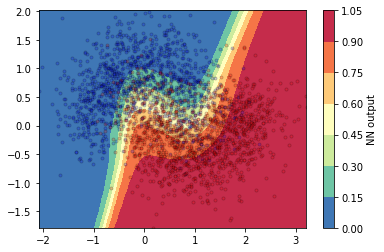

In [49]:
validate_with_generator(stupid_model, moon_generator(), steps=20)

## Backend API

While it is very well possible to operate on the underlying Tensors with TensorFlow you can also do this via the `keras.backend` API. This module wraps the around all operations to provide the mapping to the different backends (Thensorflow, Theano, CNTK). In most examples you find people will call this module `K`.

In [50]:
import keras.backend as K

Let's try to visualize the hidden layers of our first neural network in this notebook

In [51]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [52]:
model.get_layer('dense_1').output

<tf.Tensor 'dense_1/Relu:0' shape=(?, 16) dtype=float32>

In [53]:
model.input

<tf.Tensor 'dense_1_input:0' shape=(?, 2) dtype=float32>

`K.function` creates a function for us that we can feed a numpy array later. The following function will give us the output vector of the hidden layer.

In [54]:
f = K.function([model.input], [model.get_layer('dense_1').output])

Let's feed it with a regular grid again for visualization.

In [55]:
step = 0.1
grid = np.meshgrid(
    np.arange(x[:,0].min(), x[:,0].max()+step, step),
    np.arange(x[:,1].min(), x[:,1].max()+step, step)
)

In [56]:
xp = np.c_[grid[0].ravel(), grid[1].ravel()]

In [57]:
hl_out = f([xp])[0]

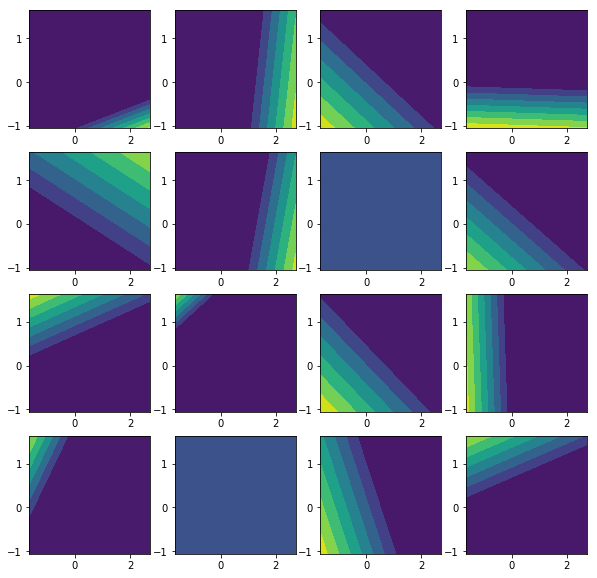

In [58]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(16):
    axs.ravel()[i].contourf(grid[0], grid[1], hl_out[:,i].reshape(grid[0].shape))